## Feature Attribution: From Simple to Integrated Gradients

- Dataset: MNIST
- Model: simple (custom) CNN

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import mnist

### Problem

When a NN makes prediction, we want to know:

 > *"Which input features (pixels) were most responsible for this output?"*

This notebook demonstrates how naive gradient-based methods can fail and how Integrated Gradients addresses these failures.

---

### Simple Gradients
A straightforward approach to interpretability is to calculate gradients of the network's output w.r.t. its input pixels:

$$\text{SimpleGrad}_i(x) = \frac{\partial{F(x)}}{\partial{x_i}}$$

But this approach yields poor (often noisy), its limitations include:
- **Saturation Problem**: Gradients may become near-zero at important pixels, incorrectly indicating that those pixels are unimportant.

- **Local Explanations**: Gradients only reflect the sensitivity of the model locally, not the cumulative importance of features.

- **Noisy Attributions**: Small perturbations can result in noisy or misleading attributions.

In [126]:
def simple_gradients(model, images, target_class_idx):
    """Calculate simple gradients of the output w.r.t. the input"""
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        outputs = predictions[:, target_class_idx]
        
    return tape.gradient(outputs, images)

### Integrated Gradients (Sundararajan et al., 2017)

The key insight: **To understand feature's importance, we should measure how the model's prediction changes as we gradually introduce that feature.**

Integrated Gradients (IG) overcome the saturation problem and offer more robust explanations by averaging gradients along a path from a baseline (often zero-valued inputs) to the actual input:

$$\text{IG}_i(x) = (x_i - x'_i) \times \int_{\alpha=0}^{1} \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x_i} d\alpha$$

Where:
- $x$ is the input
- $x'$ is the baseline (typically zeros representing "absence of feature")
- $\alpha$ is a parameter that interpolates between baseline and input

Do not look at the gradient at just the input point, but:
1. Start w/ a *baseline* (feature absence)
2. Slowly transform into the actual input
3. Track how the prediction changes along this *path*


**Path**: baseline $\to$ input
- $Path(α) = baseline + α × (input - baseline)$


**Why integration?**
- to measure the *cumulative effect* of each feature across the entire path
- at each step along the path, measure how much the output changes when the feature value is slightly increased. Then add up (integrate) all the incremental contributions to get the *total importance*.


Integrated Gradients solve key issues by:

- Accumulating gradients from regions where gradients are informative, thus overcoming local saturation.

- Providing explanations that fulfill the **completeness** property: the attributions sum exactly to the difference between the prediction at input and baseline:
$$\sum_{i} \text{IG}_i(x) = F(x) - F(x')$$


In [127]:
class IntegratedGradients:
    def __init__(self, model, baseline=None):
        self.model = model
        self.baseline = baseline
    
    def _get_gradients(self, inputs, target_class_idx):
        """Compute gradients of outputs with respect to inputs"""
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            predictions = self.model(inputs)
            outputs = predictions[:, target_class_idx]
            
        return tape.gradient(outputs, inputs)
    
    def integrated_gradients(self, input_image, target_class_idx, baseline=None, num_steps=50):
        """Calculate integrated gradients"""

        # Determine baseline, default is all zeros
        if baseline is None:
            baseline = self.baseline if self.baseline is not None else tf.zeros_like(input_image)
    
        input_image = tf.convert_to_tensor(input_image, tf.float32)
        baseline    = tf.convert_to_tensor(baseline, tf.float32)
        
        # Generate alphas for interpolation
        alphas = tf.linspace(0.0, 1.0, num_steps+1)
        # Path(alpha) = baseline * alpha (input - baseline)
        
        # Collect gradients
        gradient_list = []
        
        for alpha in alphas:
            # Calculate interpolated inputs
            interpolated_input = baseline + alpha * (input_image - baseline)
            
            # Get gradients
            gradient = self._get_gradients(interpolated_input, target_class_idx)
            gradient_list.append(gradient)
        
        # Stack and average gradients
        all_gradients = tf.stack(gradient_list, axis=0)
        avg_gradients = tf.reduce_mean(all_gradients, axis=0)
        
        # Scale attributions
        integrated_grad = (input_image - baseline) * avg_gradients

        return integrated_grad

In [128]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [129]:
def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### Visualizing Attribution Maps

In attribution maps:
- **Red (positive) values**: Features that increase the predicted probability of the target class
- **Blue (negative) values**: Features that decrease the predicted probability
- **Intensity**: Magnitude of attribution (importance)

In [130]:
def compare_attribution_methods(model, image, true_label):
    """Compare simple gradients to integrated gradients"""
    # Get model prediction
    pred = model.predict(image)
    pred_class = np.argmax(pred[0])
    confidence = pred[0][pred_class]
    
    print(f"True label: {true_label}")
    print(f"Predicted class: {pred_class} with confidence: {confidence:.4f}")
    
    # Calculate simple gradients
    simple_grads = simple_gradients(model, image, pred_class)
    simple_grads_np = simple_grads.numpy()
    
    # Calculate integrated gradients
    ig = IntegratedGradients(model)
    int_grads = ig.integrated_gradients(image, pred_class, baseline=np.zeros_like(image), num_steps=50)
    int_grads_np = int_grads.numpy()
    
    simple_grads_2d = np.squeeze(simple_grads_np)
    if simple_grads_2d.ndim == 3:  # If there's a channel dimension
        simple_grads_2d = np.sum(simple_grads_2d, axis=2)
        
    int_grads_2d = np.squeeze(int_grads_np)
    if int_grads_2d.ndim == 3:  # If there's a channel dimension
        int_grads_2d = np.sum(int_grads_2d, axis=2)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(8, 6))
    
    # Plot original image
    axes[0].imshow(np.squeeze(image), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot simple gradients
    vmax = np.max(np.abs(simple_grads_2d)) + 1e-9
    im = axes[1].imshow(simple_grads_2d, cmap='seismic', vmin=-vmax, vmax=vmax)
    axes[1].set_title('Simple Gradients')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Plot integrated gradients
    vmax = np.max(np.abs(int_grads_2d)) + 1e-9
    im = axes[2].imshow(int_grads_2d, cmap='seismic', vmin=-vmax, vmax=vmax)
    axes[2].set_title('Integrated Gradients')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Plot histogram of attribution values
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].hist(simple_grads_2d.flatten(), bins=50, alpha=0.7)
    axes[0].set_title('Simple Gradients Distribution')
    axes[0].set_xlabel('Attribution Value')
    axes[0].set_ylabel('Count')
    
    axes[1].hist(int_grads_2d.flatten(), bins=50, alpha=0.7)
    axes[1].set_title('Integrated Gradients Distribution')
    axes[1].set_xlabel('Attribution Value')
    axes[1].set_ylabel('Count')

    
    plt.tight_layout()
    plt.show()
    
    return simple_grads_np, int_grads_np

In [131]:
model = create_model()
_ = model.fit(x_train, y_train, batch_size=128, epochs=8, validation_split=0.1, verbose=1)

Epoch 1/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8487 - loss: 0.5130 - val_accuracy: 0.9825 - val_loss: 0.0633
Epoch 2/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9795 - loss: 0.0661 - val_accuracy: 0.9870 - val_loss: 0.0472
Epoch 3/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9879 - loss: 0.0401 - val_accuracy: 0.9863 - val_loss: 0.0481
Epoch 4/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9895 - loss: 0.0329 - val_accuracy: 0.9882 - val_loss: 0.0402
Epoch 5/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9927 - loss: 0.0229 - val_accuracy: 0.9880 - val_loss: 0.0445
Epoch 6/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9947 - loss: 0.0172 - val_accuracy: 0.9880 - val_loss: 0.0468
Epoch 7/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9960 - loss: 0.0136 - val_accuracy: 0.9927 - val_loss: 0.0347
Epoch 8/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9956 - loss: 0.0128 - val_accuracy: 0


--- Example 15 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
True label: 5
Predicted class: 5 with confidence: 1.0000


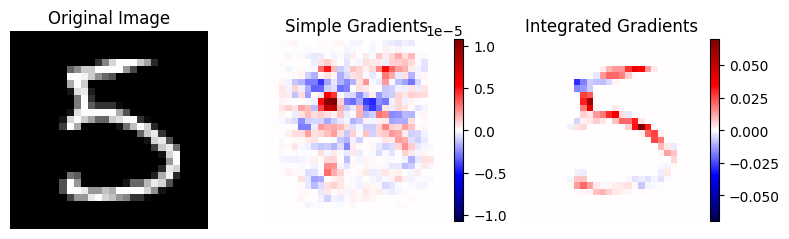

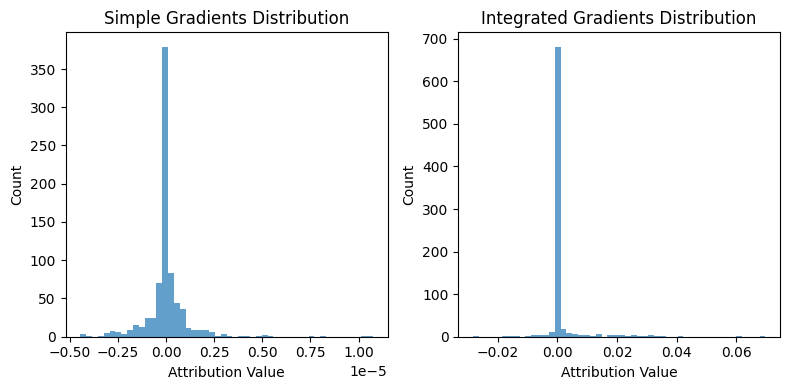


--- Example 42 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
True label: 4
Predicted class: 4 with confidence: 1.0000


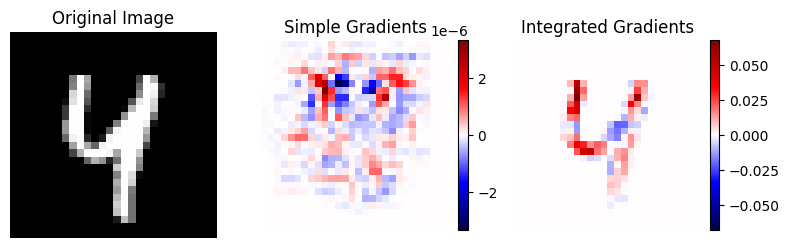

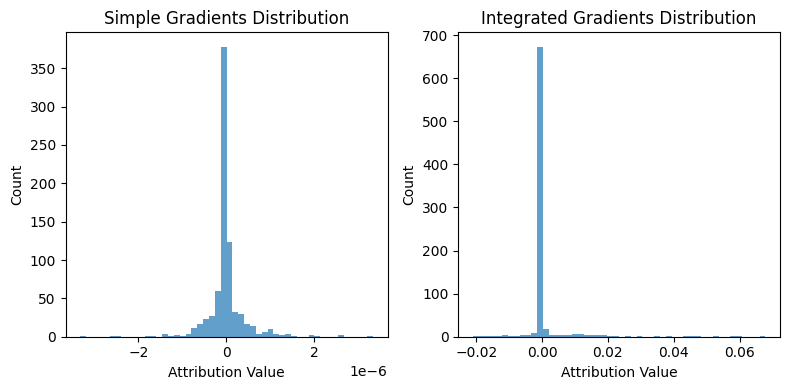


--- Example 67 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
True label: 4
Predicted class: 4 with confidence: 0.9999


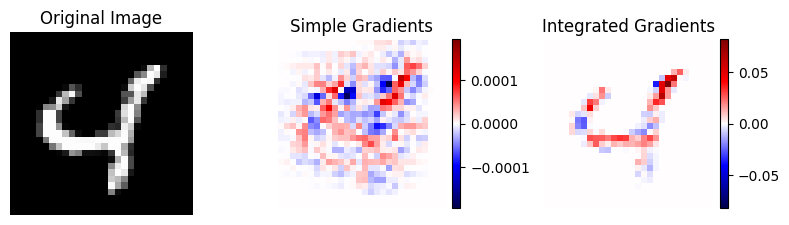

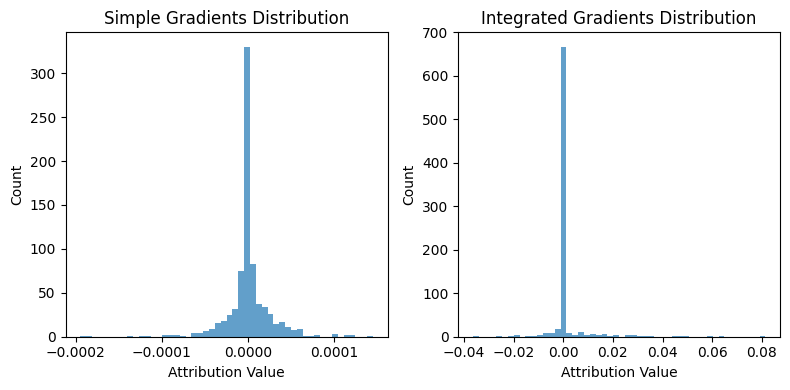

In [132]:
# Analyze a few examples
for idx in [15, 42, 67]:
    image = x_test[idx:idx+1]
    true_label = y_test[idx]
    print(f"\n--- Example {idx} ---")
    simple_grads, int_grads = compare_attribution_methods(model, image, true_label)

## Saturation Problem

The saturation problem occurs when gradients become very small (near zero) for important features.

In demo we:
1. **Identify Important Regions** using Integrated Gradients.

2. **Artificially Saturate** these regions by significantly dimming their intensity, reducing their influence on the model prediction.

3. Observe the effect on gradient-based attribution methods.

In [133]:
def demonstrate_saturation_problem(model, image, true_label):
    """Demonstrate the saturation problem with a controlled example"""
    # Get original image and prediction
    pred = model.predict(image)
    pred_class = np.argmax(pred[0])
    original_confidence = pred[0][pred_class]
    
    print(f"True label: {true_label}")
    print(f"Predicted class: {pred_class} with confidence: {original_confidence:.4f}")
    
    # Create a saturation example by modifying the image
    # - dim part of the important region to simulate saturation
    
    # Identify important regions using integrated gradients
    ig = IntegratedGradients(model)
    int_grads = ig.integrated_gradients(image, pred_class, baseline=np.zeros_like(image), num_steps=50)
    int_grads_np = int_grads.numpy()
    int_grads_2d = np.squeeze(int_grads_np)
    if int_grads_2d.ndim == 3:
        int_grads_2d = np.sum(int_grads_2d, axis=2)
    
    # Create a mask of the most important pixels
    importance_threshold = np.percentile(int_grads_2d, 90)
    important_mask = int_grads_2d > importance_threshold
    
    # Convert mask to list of coordinates
    important_coords = np.argwhere(important_mask)

    # Shuffle and select a portion (e.g., 30%) to zero
    np.random.shuffle(important_coords)
    portion_to_zero = 0.3 # 30% of important pixels
    num_to_zero = int(len(important_coords) * portion_to_zero)
    coords_to_zero = important_coords[:num_to_zero]

    # Zero out only those chosen coordinates
    saturated_image = image.copy()
    img_2d = np.squeeze(saturated_image)

    for (r, c) in coords_to_zero:
        img_2d[r, c] = 0.0

    saturated_image = np.expand_dims(img_2d, axis=(0, -1))

    # Create a saturated version of the image by reducing the intensity of important pixels
    # saturated_image = image.copy()
    # img_2d = np.squeeze(saturated_image)
    # img_2d[important_mask] *= 0.0  # dim important pixels 
    # saturated_image = np.expand_dims(img_2d, axis=(0, -1))
    
    # Get prediction on saturated image
    sat_pred = model.predict(saturated_image)
    sat_pred_class = np.argmax(sat_pred[0])
    sat_confidence = sat_pred[0][sat_pred_class]
    print(f"Saturated image - predicted class: {sat_pred_class} with confidence: {sat_confidence:.4f}")
    
    # Calculate simple gradients on saturated image
    simple_grads = simple_gradients(model, saturated_image, pred_class)
    simple_grads_np = simple_grads.numpy()
    
    # Calculate integrated gradients on saturated image
    int_grads_sat = ig.integrated_gradients(saturated_image, pred_class, baseline=np.zeros_like(image), num_steps=50)
    int_grads_sat_np = int_grads_sat.numpy()
    
    # Visualization
    simple_grads_2d = np.squeeze(simple_grads_np)
    if simple_grads_2d.ndim == 3:
        simple_grads_2d = np.sum(simple_grads_2d, axis=2)
        
    int_grads_sat_2d = np.squeeze(int_grads_sat_np)
    if int_grads_sat_2d.ndim == 3:
        int_grads_sat_2d = np.sum(int_grads_sat_2d, axis=2)
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    # Original vs Saturated images
    axes[0, 0].imshow(np.squeeze(image), cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(np.squeeze(saturated_image), cmap='gray')
    #axes[0, 1].set_title('Saturated Image\n(important pixels dimmed)')
    axes[0, 1].set_title('Saturated Image\n(30% of important pixels zeroed)')
    axes[0, 1].axis('off')
    
    # Show the important mask
    axes[0, 2].imshow(important_mask, cmap='binary')
    axes[0, 2].set_title('Important Features Mask')
    axes[0, 2].axis('off')
    
    # Simple vs Integrated gradients on saturated image
    vmax = np.max(np.abs(simple_grads_2d)) + 1e-9
    im = axes[1, 0].imshow(simple_grads_2d, cmap='seismic', vmin=-vmax, vmax=vmax)
    axes[1, 0].set_title('Simple Gradients\n(Saturation Problem)')
    axes[1, 0].axis('off')
    plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    vmax = np.max(np.abs(int_grads_sat_2d)) + 1e-9
    im = axes[1, 1].imshow(int_grads_sat_2d, cmap='seismic', vmin=-vmax, vmax=vmax)
    axes[1, 1].set_title('Integrated Gradients\n(Overcoming Saturation)')
    axes[1, 1].axis('off')
    plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    # Show difference
    diff = np.abs(int_grads_sat_2d) - np.abs(simple_grads_2d)
    vmax = np.max(np.abs(diff)) + 1e-9
    im = axes[1, 2].imshow(diff, cmap='inferno', vmin=0, vmax=vmax)
    axes[1, 2].set_title('Attribution Difference\n(IG - Simple)')
    axes[1, 2].axis('off')
    plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    simple_attr_sum = np.sum(np.abs(simple_grads_2d))
    ig_attr_sum = np.sum(np.abs(int_grads_sat_2d))
    
    print(f"Sum of absolute attributions:")
    print(f"  Simple Gradients: {simple_attr_sum:.4f}")
    print(f"  Integrated Gradients: {ig_attr_sum:.4f}")
    print(f"  Ratio (IG/Simple): {ig_attr_sum/simple_attr_sum:.2f}x")
    
    # Calculate what percentage of attributions are in important areas
    simple_important_ratio = np.sum(np.abs(simple_grads_2d[important_mask])) / simple_attr_sum
    ig_important_ratio = np.sum(np.abs(int_grads_sat_2d[important_mask])) / ig_attr_sum
    
    print(f"\nPercentage of attributions in important areas:")
    print(f"  Simple Gradients: {simple_important_ratio*100:.2f}%")
    print(f"  Integrated Gradients: {ig_important_ratio*100:.2f}%")
    
    return saturated_image


--- Saturation Problem Demonstration ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True label: 4
Predicted class: 4 with confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Saturated image - predicted class: 4 with confidence: 0.9956


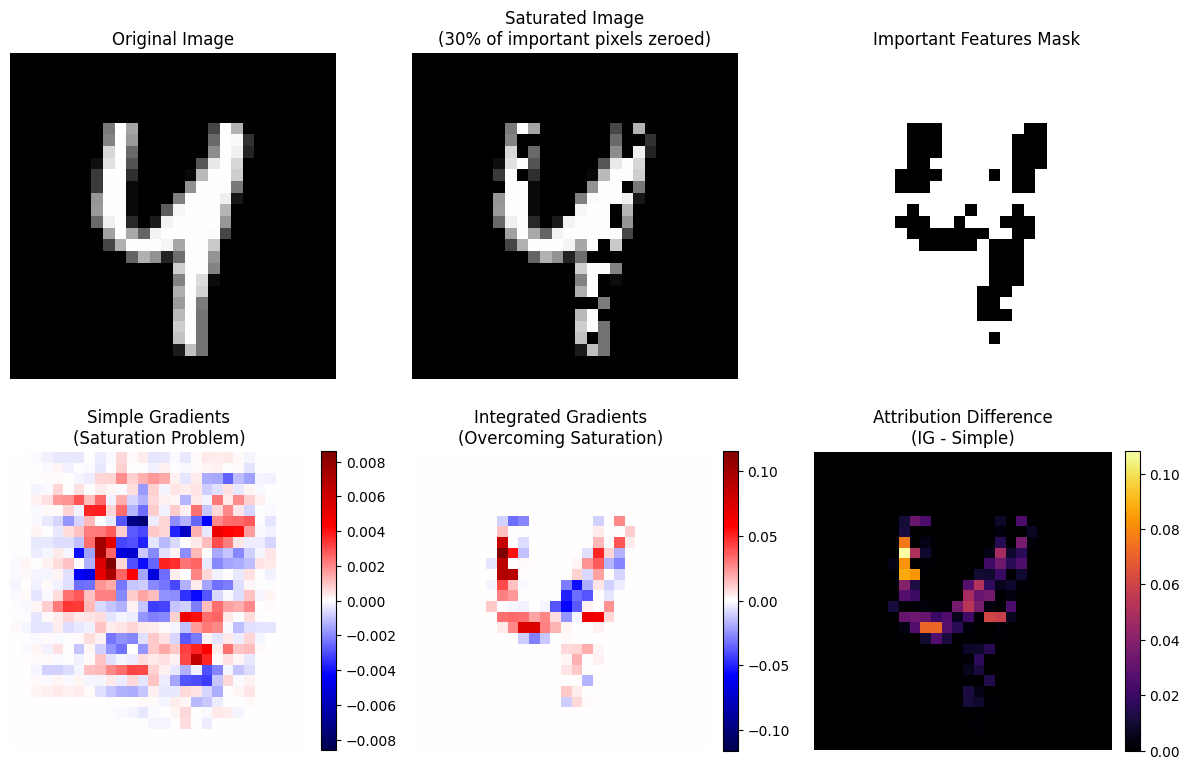

Sum of absolute attributions:
  Simple Gradients: 0.6064
  Integrated Gradients: 2.2619
  Ratio (IG/Simple): 3.73x

Percentage of attributions in important areas:
  Simple Gradients: 26.38%
  Integrated Gradients: 65.72%


In [134]:
print("\n--- Saturation Problem Demonstration ---")
saturated_image = demonstrate_saturation_problem(model, x_test[42:43], y_test[42])